In [12]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

#from imports import *
import numpy as np
import h5py
import json
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import signal
from scipy import stats
import pandas as pd
from Behavior.behavior import get_behav_units
from sessions import selected_57, selected_009266, selected_009265, selected_008229

%matplotlib inline

In [13]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [14]:
src_path = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

selected_57

['57_SIT_2023-12-18_14-07-34',
 '57_SIT_2023-12-22_14-08-07',
 '57_SIT_2023-12-22_14-43-58',
 '57_SIT_2023-12-22_17-37-18',
 '57_SIT_2023-12-23_14-21-01',
 '57_SIT_2023-12-28_16-43-28',
 '57_SIT_2023-12-29_11-06-26',
 '57_SIT_2023-12-29_11-40-14',
 '57_SIT_2023-12-29_12-11-46',
 '57_SIT_2024-01-02_14-43-18',
 '57_SIT_2024-01-02_16-38-05',
 '57_SIT_2024-01-02_17-10-09',
 '57_SIT_2024-01-03_19-22-18',
 '57_SIT_2024-01-03_19-54-59',
 '57_SIT_2024-01-04_14-16-22',
 '57_SIT_2024-01-04_14-52-59',
 '57_SIT_2024-01-05_14-35-49',
 '57_SIT_2024-01-05_15-08-34',
 '57_SIT_2024-01-06_16-52-40',
 '57_SIT_2024-01-06_17-25-35',
 '57_SIT_2024-01-07_19-23-28',
 '57_SIT_2024-01-08_15-51-26',
 '57_SIT_2024-01-12_13-23-02',
 '57_SIT_2024-01-15_13-45-22',
 '57_SIT_2024-01-15_14-34-48']

In [91]:
session = selected_57[20]
session

'57_SIT_2024-01-07_19-23-28'

In [92]:
animal     = session.split('_')[0]
meta_file  = os.path.join(src_path, animal, session, 'meta.h5')
units_file = os.path.join(src_path, animal, session, 'units.h5')
desc_file  = os.path.join(src_path, animal, session, 'descendants.h5')

with h5py.File(meta_file, 'r') as f:
    events = np.array(f['processed']['sound_events'])
    tgt_mx = np.array(f['processed']['target_matrix'])
    tl     = np.array(f['processed']['timeline'])
    trials = np.array(f['processed']['trial_idxs'])
with h5py.File(desc_file, 'r') as f:
    speed = np.array(f['speed'])
    hd    = np.array(f['hd'])
single_units, spike_times = {}, {}
with h5py.File(units_file, 'r') as f:
    unit_names = [x for x in f]
with h5py.File(units_file, 'r') as f:
    for unit_name in unit_names:
        spike_times[unit_name]  = np.array(f[unit_name][H5NAMES.spike_times['name']])
        single_units[unit_name] = np.array(f[unit_name][H5NAMES.inst_rate['name']])

In [93]:
# smooth speed a bit
width = 300  # 100 points ~= 1 sec with at 100Hz
kernel = signal.gaussian(width, std=(width) / 7.2)
#s_smooth = np.convolve(tl[:, 3], kernel, 'same') / kernel.sum()  # old speed
speed_smooth = np.convolve(speed, kernel, 'same') / kernel.sum()

In [94]:
# everything sampled in timeline space (100Hz)

# sounds
idxs_target = np.where(tl[:, 6] == 2)[0]
idxs_backgr = np.where(tl[:, 6] == 1)[0]
idxs_noise  = np.where(tl[:, 6] ==-1)[0]
idxs_reward = trials[trials[:, 5] == 1][:, 1].astype(np.int32)

# other variables: trial success, trial duration, ITI
#ITI_idxs = np.concatenate([np.where(tl[:, 6] == 0)[0], np.where(tl[:, 6] == -1)[0]])  # ITI = noise + silence

# vertical lines for events
idxs_to_idx = np.where(np.diff(idxs_backgr) > 5)[0] + 1
idxs_bgr_start = idxs_backgr[:-1][idxs_to_idx]
idxs_to_idx = np.where(np.diff(idxs_noise) > 5)[0] + 1
idxs_nos_start = np.concatenate([[idxs_noise[0]], idxs_noise[:-1][idxs_to_idx]])

# min duration in target, sec
min_dur = 0
idxs_to_idx1 = np.where(np.diff(idxs_target) > 5)[0] + 1 # target starts
idxs_to_idx2 = np.where(np.diff(idxs_target) > 5)[0][1:] # target ends
idxs_to_idx  = np.where(idxs_to_idx2 - idxs_to_idx1[:-1] > min_dur * 100)[0]
idxs_tgt_start = idxs_target[:-1][idxs_to_idx1[idxs_to_idx]]

In [95]:
# reward timeline
reward_tl = np.zeros(len(tl))
for idx in idxs_reward:
    reward_tl[idx:idx+100] = 1  # 1 second for a reward

# target sound timeline
sound_tg = np.zeros(len(tl))
sound_tg[tl[:, 6] == 2] = 1

# backgound sound
sound_bg = np.zeros(len(tl))
sound_bg[tl[:, 6] == 1] = 1

# noise
sound_ns = np.zeros(len(tl))
sound_ns[tl[:, 6] == -1] = 1

# target without reward
tgt_no_rew = np.zeros(len(tl))

In [96]:
# wall contact
# wall_con = np.zeros(len(tl))
# if events_m is not None:
#     wall_contact_recs = idxs_wall_contacts[idxs_wall_contacts[:, 2] > 0]
#     all_w_con_idxs = np.concatenate([np.arange(idx_rec[0], idx_rec[1]) for idx_rec in wall_contact_recs]).astype(np.int32)
#     wall_con[all_w_con_idxs] = 1

# # jumps
# jumps = np.zeros(len(tl))
# if events_m is not None:
#     jump_recs = idxs_wall_contacts[idxs_wall_contacts[:, 3] == 1]
#     all_jump_idxs = np.concatenate([np.arange(idx_rec[0], idx_rec[1]) for idx_rec in jump_recs]).astype(np.int32)
#     jumps[all_jump_idxs] = 1

# pellet chewing
# with h5py.File(h5name, 'r') as f:
#     pellet_s_times = np.array(f['units'][pellet_unit][H5NAMES.spike_times['name']])
#     #pellet_i_rate = np.array(f['units'][pellet_unit][H5NAMES.inst_rate['name']])
#     pellet_i_rate = instantaneous_rate(pellet_s_times, tl[:, 0], k_width=200)  # make it more crispy if needed

# idxs_pellet = np.where(pellet_i_rate > 0.4)[0]  # 0.4 Hz criteria for chewing
# idxs_to_idx = np.where(np.diff(idxs_pellet) > 5)[0] + 1
# idxs_pel_start = np.concatenate([[idxs_pellet[0]], idxs_pellet[:-1][idxs_to_idx]])

# pellet_ev = np.zeros(len(tl))
# for idx in idxs_pel_start:
#     pellet_ev[idx:idx + 5*s_rate] = 1

## Timeline

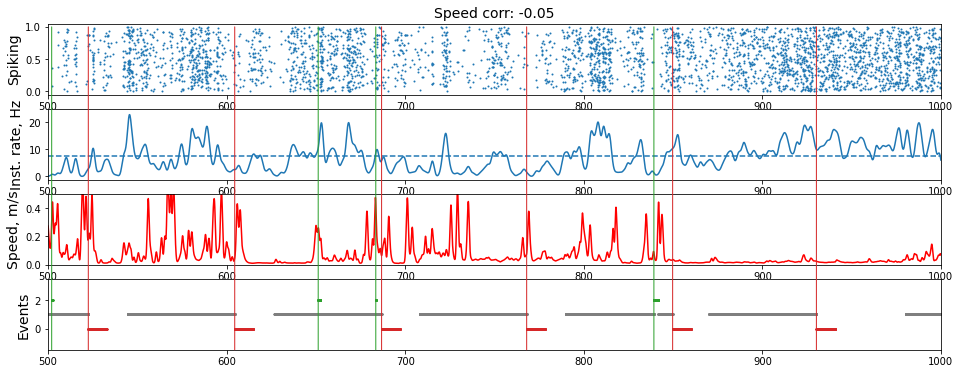

In [100]:
#unit_names = ['2-4', '2-6']
unit_names = ['3-2']#, '2-5']
              
t1, t2 = 500, 1000

fig = plt.figure(figsize=(16, len(unit_names)*4 + 2))
axes = []
for i, unit_name in enumerate(unit_names):
    s_times = spike_times[unit_name]
    i_rate  = single_units[unit_name]
    #i_rate = instantaneous_rate(s_times, tl[:, 0], k_width=30)  # make it more crispy if needed
    values = np.random.rand(len(s_times))
    speed_corr = stats.pearsonr(i_rate, speed_smooth)[0]
    
    ax = fig.add_subplot(len(unit_names)*2 + 2, 1, 2*i+1)
    ax.scatter(s_times, values, s=1)
    ax.set_xlim(t1, t2)
    ax.set_ylabel('Spiking', fontsize=14)
    ax.set_title("Speed corr: %.2f" % speed_corr, fontsize=14)
    axes.append(ax)
    
    ax2 = fig.add_subplot(len(unit_names)*2 + 2, 1, 2*i+2)
    ax2.plot(tl[:, 0], i_rate)
    ax2.axhline(i_rate.mean(), ls='--')
    ax2.set_xlim(t1, t2)
    ax2.set_ylabel('Inst. rate, Hz', fontsize=14)
    #ax2.axhline(0.4)

ax_s = fig.add_subplot(len(unit_names)*2 + 2, 1, len(unit_names)*2 + 1)
ax_s.plot(tl[:, 0], speed_smooth, color='red')
ax_s.set_xlim(t1, t2)
ax_s.set_ylim(0, .5)
ax_s.set_ylabel('Speed, m/s', fontsize=14)

ax_t = fig.add_subplot(len(unit_names)*2 + 2, 1, len(unit_names)*2 + 2)
ax_t.scatter(tl[idxs_target][:, 0], 2*np.ones(len(idxs_target)), s=1, color=COLORS[2])
ax_t.scatter(tl[idxs_backgr][:, 0], np.ones(len(idxs_backgr)), s=1, color=COLORS[4])
ax_t.scatter(tl[idxs_noise][:, 0],  np.zeros(len(idxs_noise)),  s=1, color=COLORS[3])
ax_t.scatter(tl[idxs_reward][:, 0], 2 * np.ones(len(idxs_reward)), s=50, color=COLORS[2])
ax_t.set_xlim(t1, t2)
ax_t.set_ylim(-1.5, 3.5)
ax_t.set_ylabel('Events', fontsize=14)

to_plot = [idxs_tgt_start, idxs_reward, idxs_nos_start]
colors = [COLORS[2], COLORS[2], COLORS[3], COLORS[2]]

for j, idxs_var in enumerate(to_plot):
    xy1 = np.vstack([ tl[idxs_var][:, 0],  1.0 * np.ones(len(idxs_var)) ]).T
    xy3 = np.vstack([ tl[idxs_var][:, 0], -1.5 * np.ones(len(idxs_var)) ]).T
    for i in range(len(idxs_var)):
        if xy1[i][0] < t1 or xy1[i][0] > t2:
            continue
        con = ConnectionPatch(xyA=xy1[i], coordsA=axes[0].transData, xyB=xy3[i], coordsB=ax_t.transData, color=colors[j])
        fig.add_artist(con)
#fig.tight_layout()
#fig.savefig(os.path.join(report, 'TL_%s_%s_%s.png' % (t1, t2, session)))

## Firing rate relative to event

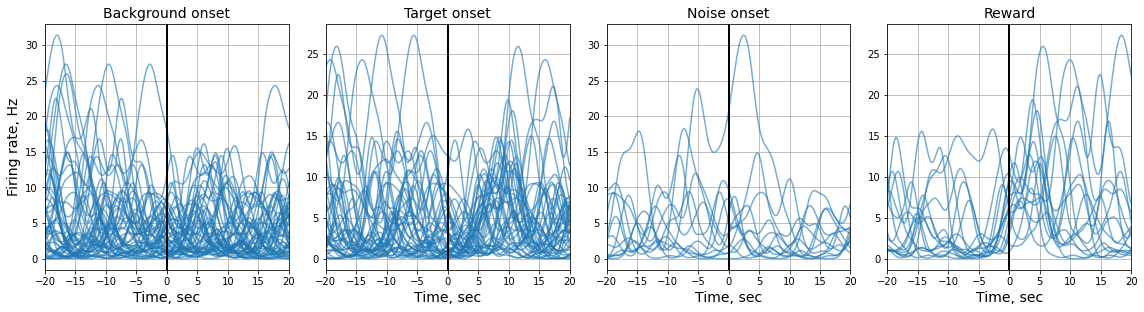

In [76]:
#unit_names = ['2-7'] 
fig = plt.figure(figsize=(16, 8))

s_rate = 100  # sampling rate 100 Hz
offset = 100 * 20  # 10 seconds
x_vals = np.linspace(-offset/s_rate, offset/s_rate, 2*offset)
titles = ['Background onset', 'Target onset', 'Noise onset', 'Reward'] # 'Pellet', 'Walls', 'Jumps', 

axes = []
for i, var_idxs in enumerate([idxs_bgr_start, idxs_tgt_start, idxs_nos_start, idxs_reward]):
                              #wall_contact_recs[:, 0].astype(np.int32), jump_recs[:, 0].astype(np.int32), \
                              #idxs_pel_start]):
    ax = fig.add_subplot(2, 4, i+1)
    
    for j, unit_name in enumerate(unit_names):
        i_rate = single_units[unit_name]
        # TODO add averages /stds
        x_coll, y_coll = [], []
        for idx in var_idxs:
            idx_x_l =  0 if idx - offset > 0 else offset - idx
            idx_x_r = len(x_vals) if idx + offset < len(i_rate) else offset + len(i_rate) - idx - 1
            idx_y_l =  0 if idx - offset < 0 else idx - offset
            idx_y_r = -1 if idx + offset > len(i_rate) else idx + offset
            ax.plot(x_vals[idx_x_l:idx_x_r], i_rate[idx_y_l:idx_y_r], color=COLORS[j], alpha=0.6)
            x_coll.append(x_vals[idx_x_l:idx_x_r])
            y_coll.append(i_rate[idx_y_l:idx_y_r])
        
    ax.set_xlim(-offset/s_rate, offset/s_rate)
    ax.axvline(0, linewidth=2, color='black')
    ax.set_title(titles[i], fontsize=14)
    ax.set_xlabel('Time, sec', fontsize=14)
    if i == 0:
        ax.set_ylabel('Firing rate, Hz', fontsize=14)
    ax.grid()
    axes.append(ax)
    
fig.tight_layout()

## 2 Units corr

In [61]:
# unit1 = '3-8'
# unit2 = '4-3'
# with h5py.File(h5name, 'r') as f:
#     i_rate1 = np.array(f['units'][unit1][H5NAMES.inst_rate['name']])
#     i_rate2 = np.array(f['units'][unit2][H5NAMES.inst_rate['name']])
# pearsonr(i_rate1, i_rate2)

(0.12341674439067918, 0.0)

## Sprints at firing

In [334]:
# unit_name = '7-6'
# with h5py.File(h5name, 'r') as f:
#     i_rate = np.array(f['units'][unit_name][H5NAMES.inst_rate['name']])
#     s_idxs = np.array(f['units'][unit_name][H5NAMES.spike_idxs['name']])
    
# idxs_active = np.where(i_rate > 0.5)[0]
# idxs_to_idx = np.where(np.diff(idxs_active) > 5)[0] + 1
# idxs_act_start = idxs_active[:-1][idxs_to_idx]

array([    39,     50,     80, ..., 239964, 239985, 239996], dtype=int32)

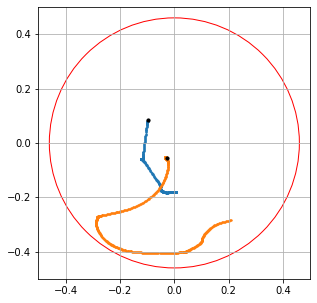

In [335]:
# t1, t2 = 1575, 1630

# selected = idxs_act_start[(tl[idxs_act_start][:, 0] > t1) & (tl[idxs_act_start][:, 0] < t2)]
# offset = 5  # secs
# s_rate = 100  # sampling rate 100 Hz

# fig = plt.figure(figsize=(5, 5))
# ax = fig.add_subplot(111)
# for idx in selected:
#     ax.scatter(tl[idx:idx + offset*s_rate][:, 1], tl[idx:idx + offset*s_rate][:, 2], s=2)
    
# ax.scatter(tl[selected][:, 1], tl[selected][:, 2], s=10, color='black')
# ax.add_patch(plt.Circle((0, 0), 0.46, color='r', fill=False))
# ax.grid()
# ax.set_xlim(-0.5, 0.5)
# ax.set_ylim(-0.5, 0.5)
# ax.set_aspect('equal')

# s_idxs

In [10]:
#source  = '/home/andrey/projects/data/'
#source  = '/home/andrey/projects/data/'
#session = '008229_hippoSIT_2022-05-13_09-48-00'
#session = '008229_hippoSIT_2022-05-13_15-17-12'
#session, pellet_unit = '008229_hippoSIT_2022-05-17_21-44-43', '1-19'  # FIXME dummy pellet unit 
#session, pellet_unit = '008229_hippoSIT_2022-05-16_20-36-44', '3-3'
#session, pellet_unit = '008229_hippoSIT_2022-05-20_15-54-39', '6-7'
#session, pellet_unit = '008229_hippoSIT_2022-05-18_14-36-18', '1-16'
#session, pellet_unit = '008229_hippoSIT_2022-05-31_11-00-02', '1-4'
#session, pellet_unit = '008229_hippoSIT_2022-05-31_16-38-23', '1-4'
#session, pellet_unit = '008229_hippoSIT_2022-06-01_11-08-51', '1-4'
#session, pellet_unit = '008229_hippoSIT_2022-06-25_17-49-10', '6-4'
#session, pellet_unit = '008229_hippoSIT_2022-06-28_10-12-19', '6-2'
#session, pellet_unit = '008228_hippoSIT_2022-05-28_12-20-33', '2-6'
#session, pellet_unit = '008228_hippoSIT_2022-06-01_10-19-39', '7-2'
#session, pellet_unit = '009265_hippoSIT_2023-03-03_09-37-07', '4-2'
#session, pellet_unit = '009265_hippoSIT_2023-02-21_20-44-17', '8-2'
#session, pellet_unit = '009266_hippoSIT_2023-04-26_08-20-17', '3-3'

animal  = session.split('_')[0]
sessionpath = os.path.join(source, animal, session)
h5name  = os.path.join(source, animal, session, session + '.h5')

events_m_file = os.path.join(source, animal, session, 'events_manual.csv')
events_m = None
if os.path.exists(events_m_file):
    # t_start, t_end, wall (E-1, S-2, W-3, N-4), jumps, intentions
    events_m = np.loadtxt(events_m_file, delimiter=',', skiprows=1)  